In [1]:
# imports
from OfflineSRL.MDPDataset.old_dataset import *
from OfflineSRL.MDP.old_MDP import MDP
from OfflineSRL.MDP.ChainBandit import ChainBanditMDP
from OfflineSRL.MDP.ChainBanditState import ChainBanditState
from OfflineSRL.BPolicy.ChainBanditPolicy import ChainBanditPolicy

# Learners
from OfflineSRL.OfflineLearners.offlineLearners import VI, PVI, SPVI, PesBandit

# GridWorld
from OfflineSRL.MDP.GridWorldMDPClass import GridWorldMDP
from OfflineSRL.MDP.GridWorldStateClass import GridWorldState
from OfflineSRL.BPolicy.UniformRandomPolicy import UniformRandomPolicy

# BluredGridWorld
from OfflineSRL.MDP.BluredGridWorldClass import BluredGridWorldMDP

import copy
import numpy as np
import math

In [2]:
def get_dataset(mdp, policy, horizon = 50, neps = 50):    
    # Generate data
    mdp.reset()
    observations = []
    actions = []
    rewards = []
    terminals = []
    for eps in range(neps):
        for timestep in range(horizon+2):
            # Get state.
            # Add state to list.
            cur_state = copy.deepcopy(mdp.cur_state)
            observations.append(copy.deepcopy(cur_state._vrepr()))

            # Get action
            # Add action to list
            cur_action = policy._get_action(state = cur_state)
            actions.append(copy.deepcopy(cur_action))

            # Execute action
            reward, next_state = mdp.execute_agent_action(cur_action)
            # Add reward
            rewards.append(copy.deepcopy(reward))

            terminals.append(0)
        mdp.reset()
        terminals[-1] = 1
        
    # Convert to MDPDataset format
    observations = np.array(observations)
    actions = np.array(actions)
    rewards = np.array(rewards)
    terminals = np.array(terminals)

    dataset = MDPDataset(
        observations=observations,
        actions=actions,
        rewards=rewards,
        terminals=terminals,
    )
    
    return observations, policy, dataset, actions, rewards, terminals

In [3]:
import math
def evaluate_learner(option, observations, mdp, policy, dataset, horizon, neps = 5000):
    max_step_reward = 1
    abs_max_ep_reward = math.inf
    min_step_reward = -1
    if option == "VI":
        vi = VI(name = "vi", states = observations, actions = policy.actions, epLen = horizon)
    if option == "PVI":
        vi = PVI(name = "pvi", states = observations, actions = policy.actions, epLen = horizon, 
                 max_step_reward = max_step_reward, min_step_reward = min_step_reward, abs_max_ep_reward = abs_max_ep_reward)
    if option == "SPVI":
        vi = SPVI(name = "spvi", states = observations, actions = policy.actions, epLen = horizon, bpolicy = policy,
                  max_step_reward = max_step_reward, min_step_reward = min_step_reward, abs_max_ep_reward = abs_max_ep_reward)
    if option == "PSL":
        vi = PesBandit(name = "psl", states = observations, actions = policy.actions, epLen = horizon)
    vi.fit(dataset)
    
    mdp.reset()
    viobservations = []
    viactions = []
    virewards = []
    viterminals = []
    for eps in range(neps):
        for timestep in range(horizon):
            # Get state.
            # Add state to list.
            cur_state = copy.deepcopy(mdp.cur_state)
            viobservations.append(copy.deepcopy(cur_state._vrepr()))

            # Get action
            # Add action to list
            cur_action = vi.act(copy.deepcopy(cur_state._vrepr()), timestep)
            viactions.append(copy.deepcopy(cur_action))

            # Execute action
            reward, next_state = mdp.execute_agent_action(cur_action)
            # Add reward
            virewards.append(copy.deepcopy(reward))

            viterminals.append(0)
        mdp.reset()
        viterminals[-1] = 1
    return np.sum(np.array(virewards))/neps

In [4]:
# Initialize MDP and Policy
#width, height = 10, 3
width, height = 8, 3
mdp = BluredGridWorldMDP(width=width,
                 height=height,
                 init_loc=(1, 1),
                 rand_init=True,
                 goal_locs=[(2,2)],
                 lava_locs=[(8,2)],
                 walls=[],
                 is_goal_terminal=True,
                 is_lava_terminal=False,
                 gamma=0.99,
                 slip_prob=0.0,
                 step_cost=0.0,
                 lava_cost=1.0,
                 name="bluredgridworld")
policy = UniformRandomPolicy(mdp)
state_list = np.array([[i,j] for i in range(width+1) for j in range(height+1)])

In [5]:
rew_dict = {}
option_list = ["PSL","PVI","SPVI"]
for option in option_list:
    rew_dict[option] = {}
n_runs = 3
horizon = max(width, height)
neps_list = [int(math.pow(2,i))*250 for i in range(15)] #+ [1000 + (i)*1000 for i in range(10)]
#neps_list = [50, 100, 200, 400, 800, 1600, 3200]
#neps_list = [50, 100, 200, 400, 800, 1600]#, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
for neps in neps_list:
    print(neps)
    for option in option_list:
        rew_dict[option][neps] = []
    for run in range(n_runs):
        observations, policy, dataset, actions, rewards, terminals = get_dataset(mdp, policy, horizon = horizon, neps = neps)
        for option in option_list:
            rew_dict[option][neps].append(evaluate_learner(option, state_list, mdp, policy, dataset, horizon))
            #print(option)
            #print(option, neps, evaluate_learner(option, copy.deepcopy(observations), policy, dataset, horizon))

250
500
1000
2000
4000
8000
16000
32000
64000
128000
256000
512000
1024000
2048000
4096000


In [6]:
rew = {}
err = {}
for option in option_list:
    rew[option] = []
    err[option] = []
for neps in neps_list:
    for option in option_list:
        rew[option].append(np.mean(rew_dict[option][neps]))
        err[option].append(np.std(rew_dict[option][neps])/np.sqrt(n_runs))

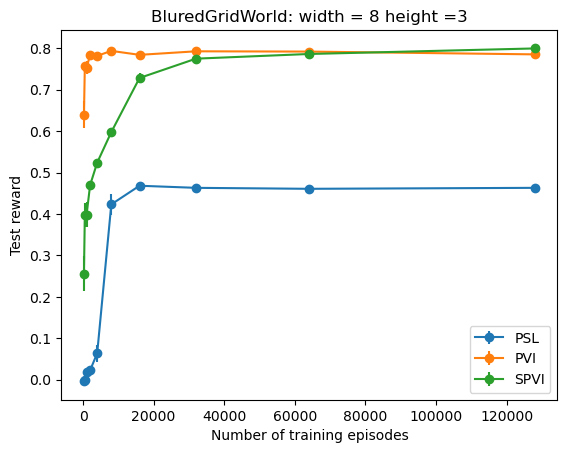

In [10]:
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

fig, ax = plt.subplots()
for option in option_list:
    x = neps_list[:10]
    y = rew[option][:10]
    yerr = err[option][:10]
    ax.errorbar(x, y,
                yerr=yerr,
                fmt='-o', label = option)


ax.set_xlabel('Number of training episodes')
ax.set_ylabel('Test reward')
ax.set_title('BluredGridWorld: width = '+str(width)+' height ='+str(height))
plt.legend()

plt.savefig('BluredGridWorld: width = '+str(width)+' height ='+str(height))
plt.show()

In [8]:
rew

{'PSL': [-0.003933333333333333,
  -0.001266666666666666,
  0.0196,
  0.022866666666666664,
  0.06373333333333334,
  0.42313333333333336,
  0.46806666666666663,
  0.463,
  0.4606666666666667,
  0.463,
  0.4746666666666666,
  0.4652,
  0.46186666666666665,
  0.46446666666666664,
  0.47266666666666673],
 'PVI': [0.6389333333333332,
  0.7561333333333334,
  0.7529333333333333,
  0.7837333333333333,
  0.7815333333333333,
  0.7934666666666667,
  0.7839333333333333,
  0.7924666666666665,
  0.7918,
  0.7850666666666667,
  0.7923999999999999,
  0.7844000000000001,
  0.7886666666666667,
  0.7892666666666667,
  0.7892666666666667],
 'SPVI': [0.2562666666666667,
  0.3978,
  0.39866666666666667,
  0.4698,
  0.5237333333333334,
  0.5975333333333334,
  0.7281333333333334,
  0.7747333333333333,
  0.786,
  0.7994,
  0.7811333333333333,
  0.7756,
  0.7837999999999999,
  0.7998,
  0.7757999999999999]}

In [11]:
rew_dict

{'PSL': {250: [0.0016, -0.009, -0.0044],
  500: [-0.0162, 0.0016, 0.0108],
  1000: [0.0272, -0.003, 0.0346],
  2000: [0.001, 0.0208, 0.0468],
  4000: [0.1136, 0.0482, 0.0294],
  8000: [0.4566, 0.453, 0.3598],
  16000: [0.468, 0.4634, 0.4728],
  32000: [0.4508, 0.4882, 0.45],
  64000: [0.452, 0.4666, 0.4634],
  128000: [0.449, 0.4624, 0.4776],
  256000: [0.4826, 0.4628, 0.4786],
  512000: [0.4608, 0.4498, 0.485],
  1024000: [0.4604, 0.461, 0.4642],
  2048000: [0.4488, 0.4786, 0.466],
  4096000: [0.4536, 0.4706, 0.4938]},
 'PVI': {250: [0.6666, 0.5606, 0.6896],
  500: [0.7346, 0.76, 0.7738],
  1000: [0.785, 0.7524, 0.7214],
  2000: [0.7878, 0.7796, 0.7838],
  4000: [0.7676, 0.7822, 0.7948],
  8000: [0.7934, 0.7932, 0.7938],
  16000: [0.7836, 0.78, 0.7882],
  32000: [0.7962, 0.8128, 0.7684],
  64000: [0.7898, 0.7794, 0.8062],
  128000: [0.7744, 0.7982, 0.7826],
  256000: [0.793, 0.8088, 0.7754],
  512000: [0.795, 0.7902, 0.768],
  1024000: [0.7882, 0.7966, 0.7812],
  2048000: [0.8034, 0.7

In [13]:
# open file for writing
f = open('BluredGridWorld: width = '+str(width)+' height ='+str(height)+".txt","w")

# write file
f.write( str(rew_dict) )

# close file
f.close()
